In [1]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.scale(140)
cluster

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [2]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.3:46388 Dashboard: http://172.30.100.3:40743/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7646642     hsw24 make_pro albert7a PD       0:00      1 (Resources)
           7646643     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           7646644     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           7646640     hsw24 make_pro albert7a  R       0:00      1 n2563
           7646641     hsw24 make_pro albert7a  R       0:00      1 n2665
           7646632     hsw24 make_pro albert7a  R       1:01      1 n2362
           7646633     hsw24 make_pro albert7a  R       1:01      1 n2363
           7646634     hsw24 make_pro albert7a  R       1:01      1 n3017
           7646635     hsw24 make_pro albert7a  R       1:01      1 n3018
           7646636     hsw24 make_pro albert7a  R       1:01      1 n2562


In [4]:
import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

52


In [5]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7646642     hsw24 make_pro albert7a PD       0:00      1 (Resources)
           7646643     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           7646644     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           7646640     hsw24 make_pro albert7a  R       0:11      1 n2563
           7646641     hsw24 make_pro albert7a  R       0:11      1 n2665
           7646632     hsw24 make_pro albert7a  R       1:12      1 n2362
           7646633     hsw24 make_pro albert7a  R       1:12      1 n2363
           7646634     hsw24 make_pro albert7a  R       1:12      1 n3017
           7646635     hsw24 make_pro albert7a  R       1:12      1 n3018
           7646636     hsw24 make_pro albert7a  R       1:12      1 n2562


In [6]:
import sys
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob

%matplotlib inline


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [7]:
#params

plot_eke_monthly=False
plot_eke_12_month=True
plot_eke_annual=False


In [8]:
config='GS36'
case='MPC001'
freq='1d'
year='2010'

datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
#!ls $datadir
gridfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36_coordinates.nc'
maskfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36.L75-MAA007_mesh_mask.nc'

In [9]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

In [10]:
def compute_EKE(u2,v2,u2mean,v2mean):
    ua=0.5*((-1*u2+u2mean)+(-1*u2.shift(x=1)+u2mean.shift(x=1)))
    va=0.5*((-1*v2+v2mean)+(-1*v2.shift(y=1)+v2mean.shift(y=1)))
    uat=ua.rename({'depthu':'deptht'})
    vat=va.rename({'depthv':'deptht'})
    eke=0.5*(uat+vat)
    return eke


In [11]:
month_name={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
def plot_monthly(var,mask,vmin,vmax,cmap,title,figfile):
    fig, axes = plt.subplots(3,4,figsize=(30,20))
    axes = axes.ravel()
    for m in np.arange(1,13):
        if m < 10:
            month='0'+str(m)
        else:
            month=str(m)
        if m in [1,3,5,7,8,10,12]:
            dayf='31'
        elif m == 2:
            dayf='28'
        else:
            dayf='30'
        ax=axes[m-1]
        var.sel(time_counter=slice('2010-'+month+'-01','2010-'+month+'-'+dayf)).mean(dim='time_counter').where(mask==1).plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
        ax.set_title(month_name[m])
    fig.suptitle('Monthly mean of '+str(title))
    plt.savefig(config+'-'+case+'y'+str(year)+'.1m_'+figfile+'.png')

In [12]:
month_name={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
def plot_one_month(var,mask,vmin,vmax,cmap,title,figfile,m):
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    if m < 10:
        month='0'+str(m)
    else:
        month=str(m)
    if m in [1,3,5,7,8,10,12]:
        dayf='31'
    elif m == 2:
        dayf='28'
    else:
        dayf='30'
    var.sel(time_counter=slice('2010-'+month+'-01','2010-'+month+'-'+dayf)).mean(dim='time_counter').where(mask==1).plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
    ax.set_title(month_name[m])
    fig.suptitle('Monthly mean of '+str(title))
    plt.savefig(config+'-'+case+'y'+str(year)+'m'+str(month)+'_'+figfile+'.png')

In [13]:
def plot_annual(var,mask,vmin,vmax,cmap,title,figfile):
    fig, ax = plt.subplots(1,1,figsize=(10,15))
    var.mean(dim='time_counter').where(mask==1).plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
    fig.suptitle('Annual mean of '+str(title))
    plt.savefig(config+'-'+case+'_y'+str(year)+'.1y_'+figfile+'.png')    

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


RuntimeError: NetCDF: HDF error

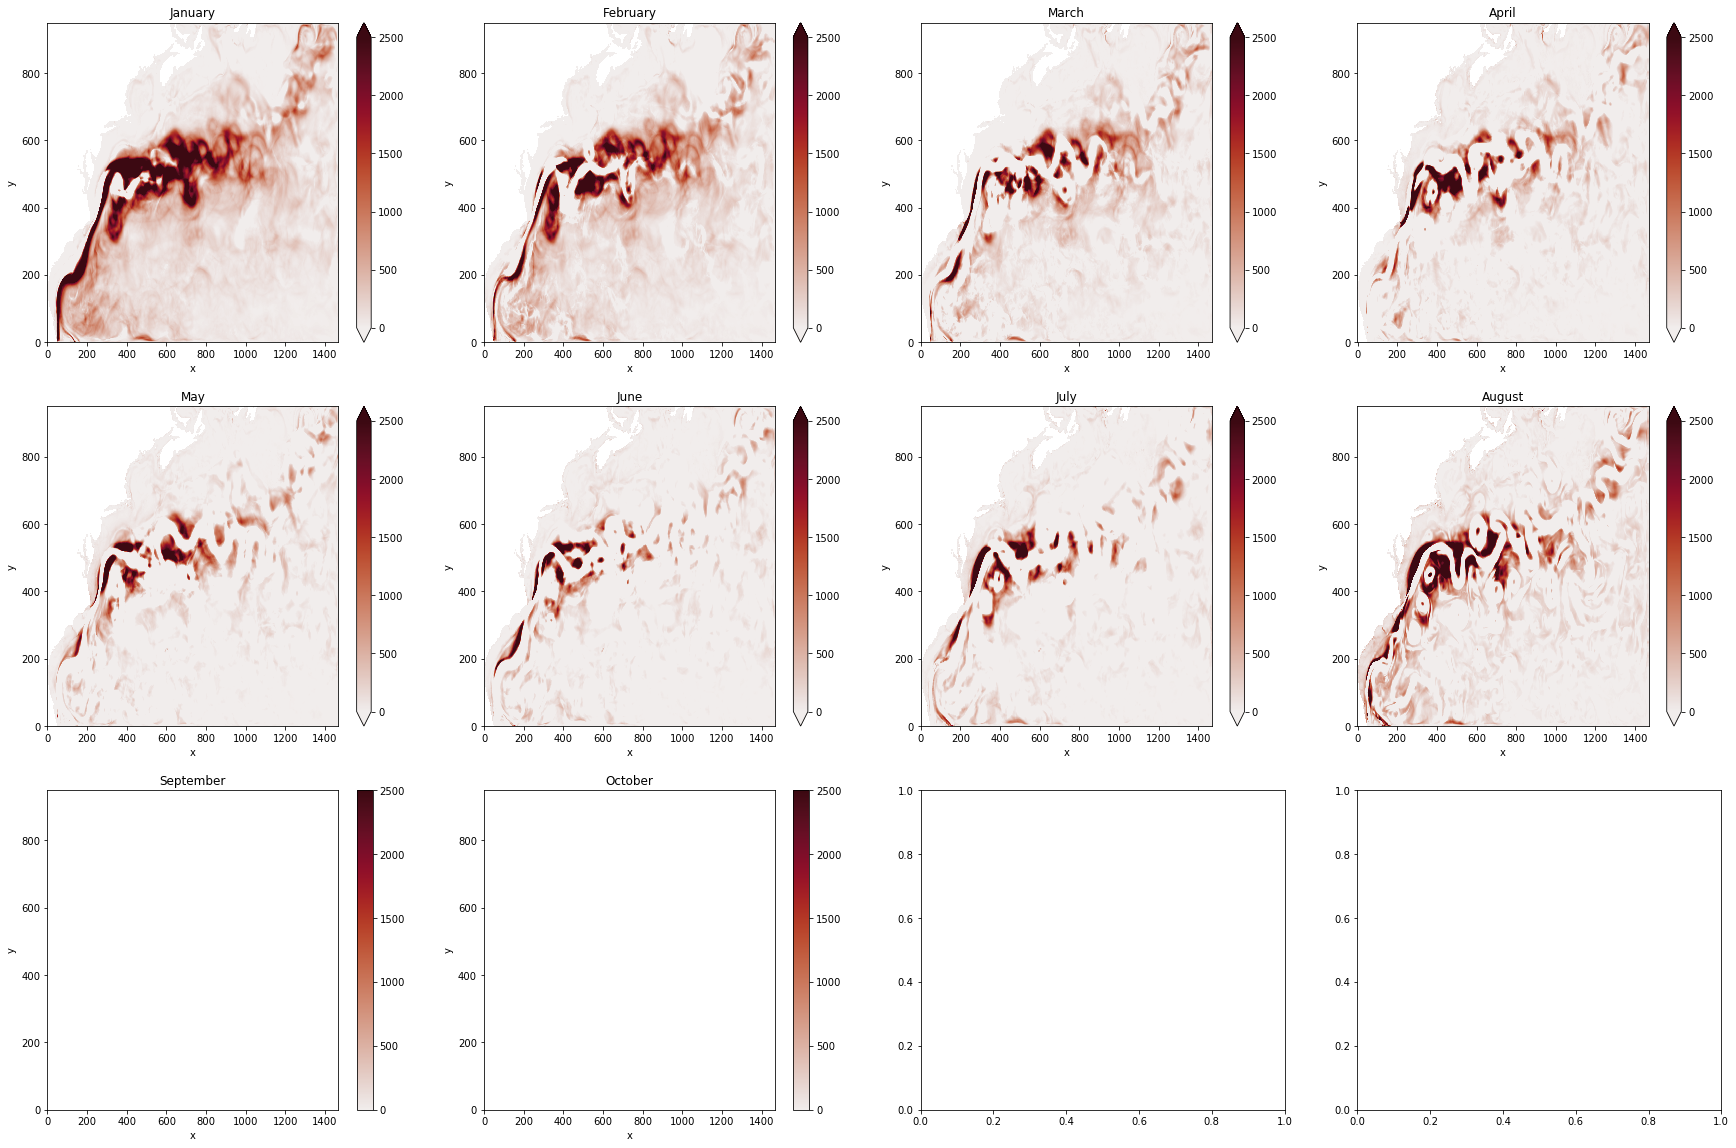

In [15]:
if plot_eke_monthly==True:
    filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridU.nc'))
    filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridV.nc'))
    dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':1,'depthu':1})
    dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':1,'depthv':1})
    u=dsU.vozocrtx
    v=dsV.vomecrty
    mask=dsmask.tmask[0]
    u2=u*u
    v2=v*v
    u2mean=u2.mean(dim='time_counter')
    v2mean=v2.mean(dim='time_counter')
    eke=compute_EKE(u2,v2,u2mean,v2mean)
    plot_monthly(10000*eke[:,0],mask[0],0,2500,'cmo.amp','Surface EKE','eke_surf')


In [ ]:
if plot_eke_12_month==True:
    filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridU.nc'))
    filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridV.nc'))
    dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':1,'depthu':1})
    dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':1,'depthv':1})
    u=dsU.vozocrtx
    v=dsV.vomecrty
    mask=dsmask.tmask[0]
    u2=u*u
    v2=v*v
    u2mean=u2.mean(dim='time_counter')
    v2mean=v2.mean(dim='time_counter')
    eke=compute_EKE(u2,v2,u2mean,v2mean)
    for m in np.arange(1,13):
        plot_one_month(10000*eke[:,0],mask[0],0,3500,'cmo.amp','Surface EKE','eke_surf',m)
   

In [ ]:
if plot_eke_annual==True:
    filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridU.nc'))
    filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridV.nc'))
    dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':1,'depthu':1})
    dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':1,'depthv':1})
    u=dsU.vozocrtx
    v=dsV.vomecrty
    mask=dsmask.tmask[0]
    u2=u*u
    v2=v*v
    u2mean=u2.mean(dim='time_counter')
    v2mean=v2.mean(dim='time_counter')
    eke=compute_EKE(u2,v2,u2mean,v2mean)
    plot_annual(10000*eke[:,0],mask[0],0,2500,'cmo.amp','Surface EKE','eke_surf')


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
